In [1]:
from optimization_func import simulated_annealing
from helper import mse, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
import multiprocessing as mp
from workers import vary_T_worker
t, P = get_predator_prey_data()
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats

In [32]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [33]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

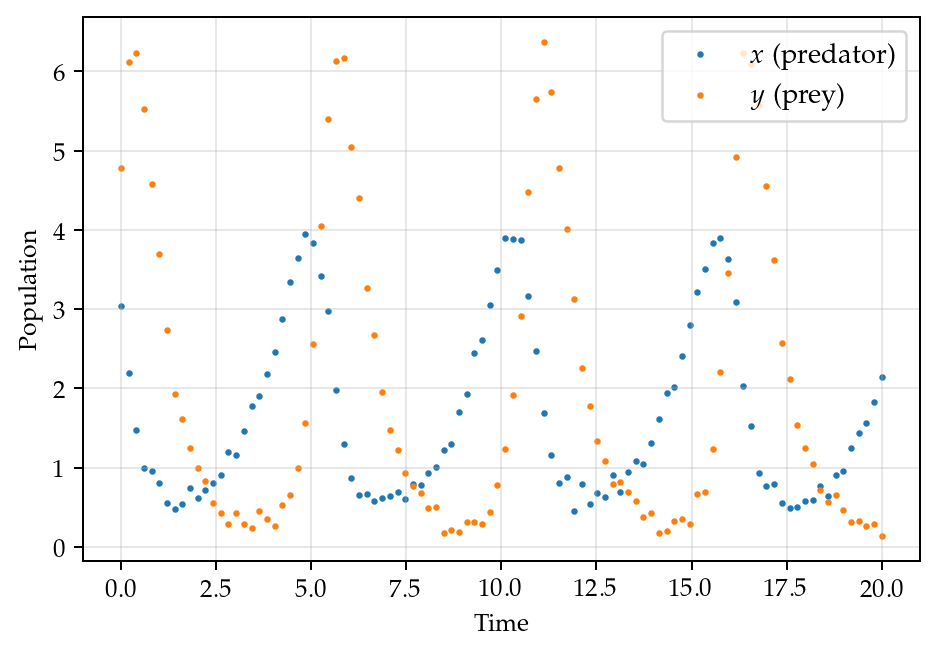

In [125]:
#plt.plot(t, z[0], label="$x$ fit", alpha=0.7)
#plt.plot(t, z[1], label="$y$ fit", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("figures/data_points.pdf", bbox_inches="tight")
plt.show()

# Parameter Tuning

### Cooling schedules visualization

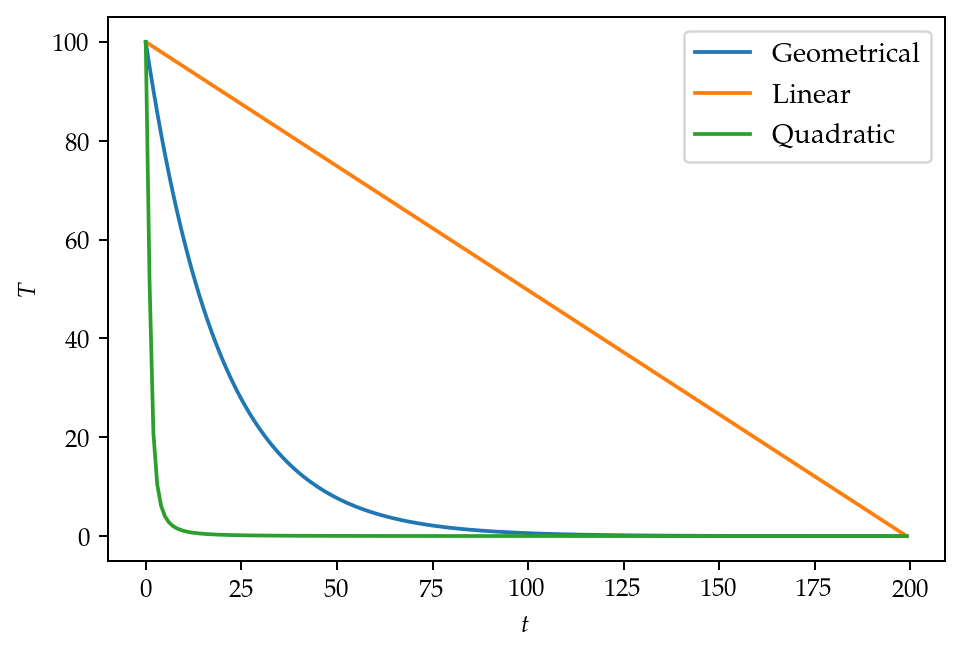

In [4]:
T_start = 100
T_steps = 200
alpha = 0.95

T_sched_geo =  [T_start*alpha**k for k in range(T_steps)]
T_sched_lin = np.linspace(T_start, 1e-5, T_steps)
T_sched_quad = [T_start/(1 + alpha*k**2) for k in range(T_steps)]


plt.plot(T_sched_geo, label="Geometrical")
plt.plot(T_sched_lin, label="Linear")
plt.plot(T_sched_quad, label = "Quadratic")
plt.legend()
plt.ylabel("$T$")
plt.xlabel("$t$")
plt.savefig("figures/cooling_schedules.pdf", bbox_inches="tight")
plt.show()

### Choice Of T0 (start Temperature)

In [9]:
def generate_initial_temperature(Ts, n=20):
    s0s = np.random.uniform(low=0.5, high=4, size=(5, 4))
    ratio_means = []
    ratio_stdevs = []
    
    for T in Ts:
        accepted_ratios = []
        for s0 in s0s:
            for i in range(n):
                _, accepted_ratio = simulated_annealing(s0, t, P, T_start=T, T_steps=200, alpha=1)
                accepted_ratios.append(accepted_ratio)
        ratio_means.append(np.mean(accepted_ratios))
        ratio_stdevs.append(np.std(accepted_ratios))
            
    return np.array(ratio_means), np.array(ratio_stdevs)

In [10]:
if False:
    shelf = shelve.open("Arrays/t0_parameter")
    
    Ts = np.linspace(1, 1000, 20, dtype=int)
    np.random.seed(111)
    ratio_means, ratio_stdevs = generate_initial_temperature(Ts)

    shelf["means"] = ratio_means
    shelf["stdevs"] = ratio_stdevs
    shelf.close()

In [11]:
shelf = shelve.open("Arrays/t0_parameter")
ratio_means, ratio_stdevs = shelf["means"], shelf["stdevs"]
shelf.close()

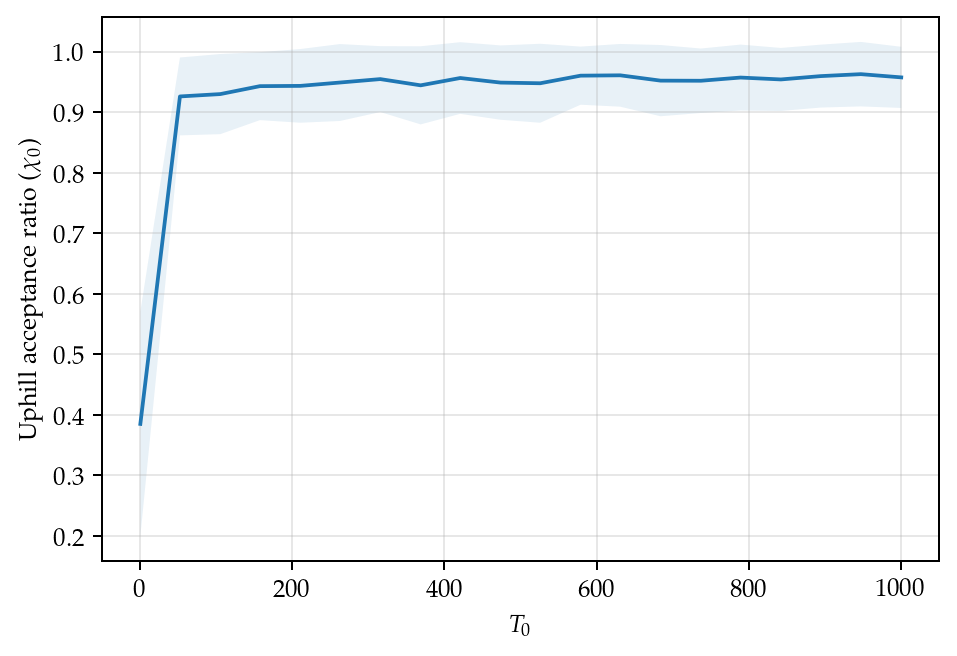

In [18]:
Ts = np.linspace(1, 1000, 20, dtype=int)
plt.plot(Ts, ratio_means)
plt.fill_between(Ts, ratio_means - ratio_stdevs, ratio_means + ratio_stdevs, alpha=0.1)
#plt.ylim(0.5, 1.05)
plt.xlabel("$T_0$")
plt.ylabel("Uphill acceptance ratio ($\\chi_0$)")
plt.grid(alpha=0.3)
plt.savefig("figures/t0_acceptance_ratio.pdf", bbox_inches="tight")
plt.show()

### Choice of T steps (iterations)

In [6]:
def rvs_generator(n_rv = 10):
    return np.random.uniform(low=0.5, high=2, size=(n_rv,4))


def Vary_T_steps(cooling_schedule, rvs, n_sim = 10, T_start = 200):
    T_steps_range = np.linspace(100, 5000, 20, dtype=int) 
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(T_steps_range)):
        results.append(manager.list())
        for _ in range(n_sim):
            for rv in rvs:
                work_queue.put((T_steps_range[i], i, rv))

    processes = []

    for i in range(11):
        p = mp.Process(target=vary_T_worker, args=(
            work_queue, results, T_start, t, P, cooling_schedule
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], T_steps_range


In [26]:
%%time
np.random.seed(692304)
rvs = rvs_generator(n_rv = 5)

if True: 
    shelf = shelve.open("Arrays/T_parameter")
    #T_vary_geo, T_steps_range = Vary_T_steps(cooling_schedule="geometrical", rvs=rvs)
    #shelf["T_vary_geo"] = T_vary_geo
    #shelf["T_steps_range"] = T_steps_range
    
    #T_vary_lin, _ = Vary_T_steps(cooling_schedule="linear", rvs=rvs)
    #shelf["T_vary_lin"] = T_vary_lin
    
    T_vary_quad, _ = Vary_T_steps(cooling_schedule="quadratic", rvs=rvs)
    shelf["T_vary_quad"] = T_vary_quad
    
    shelf.close() 

Wall time: 17min 57s


In [28]:
print(np.mean(T_vary_geo, axis = 1))
print(np.median(T_vary_geo, axis = 1))
print(np.var(T_vary_geo, axis = 1))
print(np.min(T_vary_geo, axis = 1))
print(np.max(T_vary_geo, axis = 1))

print("linear")
print(np.mean(T_vary_lin, axis = 1))
print(np.median(T_vary_lin, axis = 1))
print(np.var(T_vary_lin, axis = 1))
print(np.min(T_vary_lin, axis = 1))
print(np.max(T_vary_lin, axis = 1))

print("quadratic")
print(np.mean(T_vary_quad, axis = 1))
print(np.median(T_vary_quad, axis = 1))
print(np.var(T_vary_quad, axis = 1))
print(np.min(T_vary_quad, axis = 1))
print(np.max(T_vary_quad, axis = 1))


[5.55852357 4.03345242 4.24907666 3.64738145 2.98235914 3.58975394
 2.99483346 3.87213929 2.73934508 3.26659246 4.38826817 3.02802154
 2.73888757 2.17669592 3.26203042 2.27391046 2.8044357  2.88917986
 3.21511763 1.84628582]
[6.93546203 2.65135439 5.79043541 5.6646259  0.59381563 5.75998359
 0.4427238  5.79368038 0.17009368 2.90513664 5.71869426 0.39508242
 0.1635614  0.06347956 2.96074574 0.08883633 0.0763934  0.0881222
 5.63612569 0.04205187]
[ 7.63417819 10.70969507 12.67150743 11.23278253  9.23092899 10.57965196
 10.21357955  9.82857439  9.82129203 10.73400625  9.28483216  9.73738059
  9.28962604  8.87733192 10.74439043  8.83954296  9.17603017 10.67425457
  8.70004229  7.73718991]
[0.44494685 0.06000585 0.05030548 0.02861598 0.0197441  0.02273226
 0.0245904  0.02366287 0.02336952 0.02424183 0.0220573  0.02144627
 0.01839901 0.02060157 0.0211614  0.01965249 0.02183838 0.01819078
 0.02016249 0.01901709]
[10.22277372  9.9555114  10.26286461  9.48654911  7.46952677  7.61197245
  9.7532

In [27]:
#Open data
shelf = shelve.open("Arrays/T_parameter")
T_vary_geo = shelf["T_vary_geo"] 
T_steps_range = shelf["T_steps_range"] 
T_vary_lin = shelf["T_vary_lin"] 
T_vary_quad = shelf["T_vary_quad"] 
shelf.close() 

In [43]:
def vary_T_steps_plotter(Geo_data, Lin_data, Quad_data, T_steps_range):
    datasets = [Geo_data, Lin_data, Quad_data]
    colors = ["tab:pink", "tab:olive", "tab:cyan"]
    for i in range(len(datasets)):
        mean = np.mean(datasets[i], axis = 1)
        min_ = np.min(datasets[i], axis = 1)
        max_ = np.max(datasets[i], axis = 1)
        a = [sp_confidence_interval(samples) for samples in np.array(datasets[i])]
        plt.plot(T_steps_range, mean, color = colors[i])
        plt.fill_between(T_steps_range, min_, max_, alpha=0.1, color = colors[i])
        plt.errorbar(T_steps_range, mean, yerr=a, color = colors[i], capsize = 1, elinewidth=0.5, markeredgewidth=1)
        plt.grid(alpha=0.3)
        plt.ylabel("MSE")
        plt.xlabel("Markov Chain Length ($k$)")
        #plt.legend(["Geometric schedule", "Linear schedule", "Quadratic schedule"])
        plt.show()         

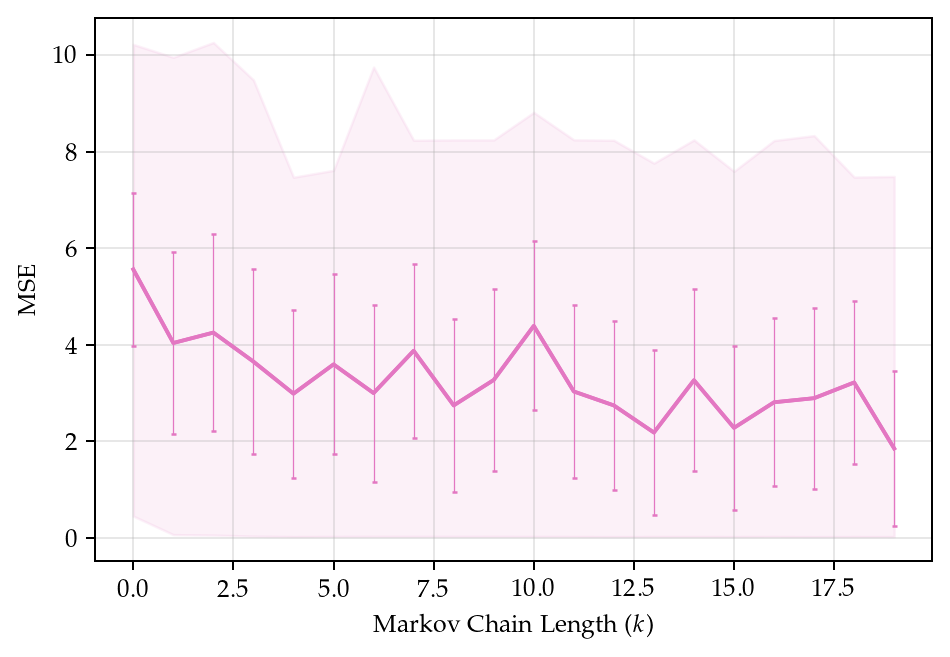

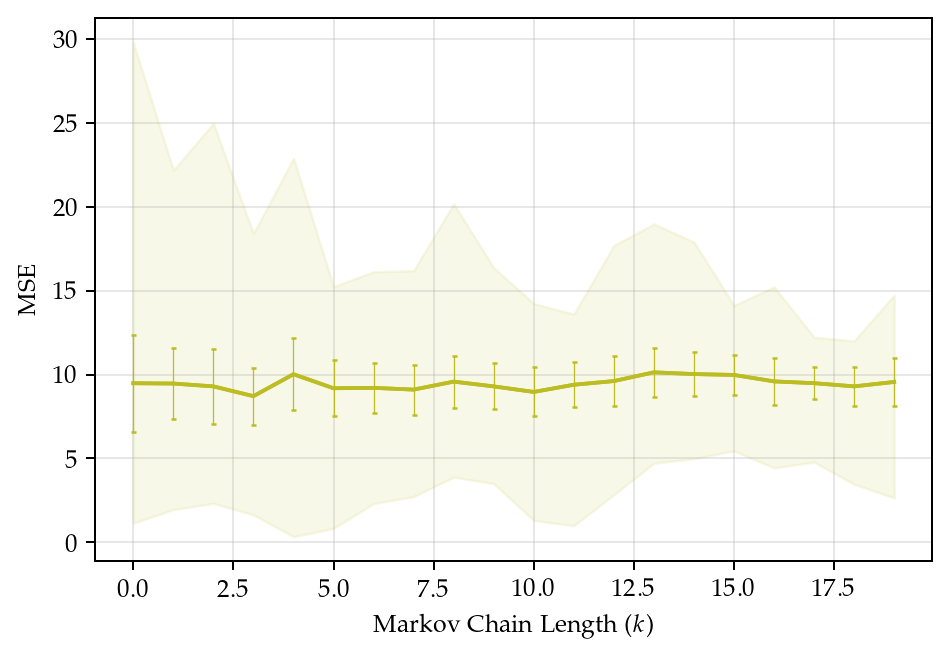

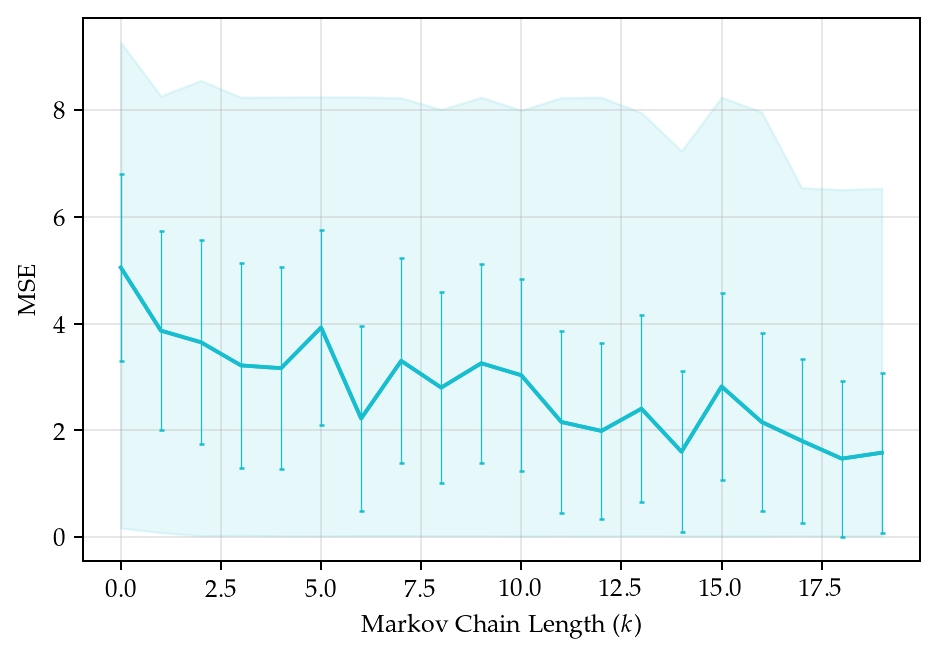

In [44]:
Test_data = np.random.normal(size = (20,10))
vary_T_steps_plotter(T_vary_geo, T_vary_lin, T_vary_quad, range(0,20))

# Solution Testing and plotting

In [126]:
#np.random.seed(1212)
s0 = [1, 1, 0.21, 1]
print(int_cost_lotka_volterra(s0, P, t, cost=mse))
x, _, _ = simulated_annealing(s0, t, P, T_start=200, T_steps=5000)

57.42093030482687


In [127]:
print(x)

[0.72611706 0.63052079 0.82271221 0.93630049]


6.31611482131245


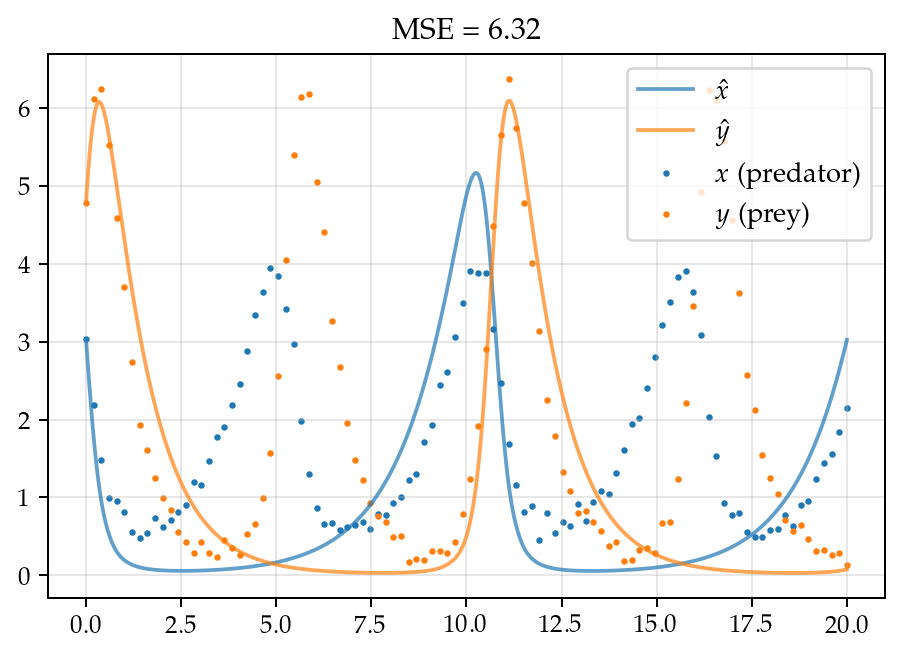

In [128]:
from scipy.integrate import solve_ivp
import numpy as np

sol_opt = solve_ivp(lotka_volterra, (t[0], t[-1]), P[0], args=x, dense_output=True)
z_opt = sol_opt.sol(t)
ts = np.linspace(t[0], t[-1], 500)
z_opt_smooth = sol_opt.sol(ts)

mse_ = mse(P, z_opt.T)
print(mse_)

plt.plot(ts, z_opt_smooth[0], label="$\\hat{x}$", alpha=0.7)
plt.plot(ts, z_opt_smooth[1], label="$\\hat{y}$", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.title(f"MSE = ${mse_:.2f}$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()